# Iris Clasification Program - TensorFlow Test Program
This program comes from TensorFlow's tutorial in https://www.tensorflow.org/get_started/eager. I just made it into a simpler jupyter notebook to get familiar with the API.

## Program Set Up

Install latest version of TensorFlow

In [1]:
!pip install -q --upgrade tensorflow

Configure imports and eager execution (Eager execution makes TensorFlow evaluate operations immediately, returning concrete values instead of creating a computational graph that is executed later)

In [ ]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

## Import and parse the training dataset

### Download the Dataset

In [ ]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

### Inspect the Data

In [4]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


 - The first line is a header containing information about the dataset:
 - There are 120 total examples. Each example has four features and one of three possible label names.
 - Subsequent rows are data records, one example per line, where:
 - The first four fields are features: these are characteristics of an example. Here, the fields hold float numbers representing flower measurements.
 - The last column is the label: this is the value we want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a flower name (setosa, versicolor, and virginica respectively).

### Parse the Dataset

In [5]:
def parse_csv(line):
    example_defaults = [[0.], [0.], [0.], [0.], [0]]  # sets field types
    parsed_line = tf.decode_csv(line, example_defaults)
    # First 4 fields are features, combine into single tensor
    features = tf.reshape(parsed_line[:-1], shape=(4,))
    # Last field is the label
    label = tf.reshape(parsed_line[-1], shape=())
    return features, label

### Create the training tf.data.Dataset

In [6]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)

# View a single example entry from a batch
features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor([6.1 2.9 4.7 1.4], shape=(4,), dtype=float32)
example label: tf.Tensor(1, shape=(), dtype=int32)


## Select the Model

Different models determine the relationships between variables (petal and sepal measurements in this case) to a particular label (species).

Neural networks can find complex relationships between features and the label.

<img src="neural_network_visual.png" width="500px">

<center>A neural network with features, hidden layers, and predictions</center>

### Create a Model Using Keras

The tf.keras.Sequential model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, two Dense layers with 10 nodes each, and an output layer with 3 nodes representing our label predictions. The first layer's input_shape parameter corresponds to the amount of features from the dataset, and is required.

In [7]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(3)
])

The activation function determines the output of a single neuron to the next layer. This is loosely based on how brain neurons are connected. There are many available activations, but ReLU is common for hidden layers.

The ideal number of hidden layers and neurons depends on the problem and the dataset. Like many aspects of machine learning, picking the best shape of the neural network requires a mixture of knowledge and experimentation. As a rule of thumb, increasing the number of hidden layers and neurons typically creates a more powerful model, which requires more data to train effectively.

## Train the Model

### Define the Loss and Gradient Function

Both training and evaluation stages need to calculate the model's loss. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing.

In [8]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
    with tfe.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

Our model will calculate its loss using the tf.losses.sparse_softmax_cross_entropy function which takes the model's prediction and the desired label. The returned loss value is progressively larger as the prediction gets worse.

The grad function uses the loss function and the tfe.GradientTape to record operations that compute the gradients used to optimize our model. For more examples of this, see the eager execution guide.

### Create an optimizer

An optimizer applies the computed gradients to the model's variables to minimize the loss function.

In [9]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

### Training Loop

- Iterate each epoch. An epoch is one pass through the dataset.
- Within an epoch, iterate over each example in the training Dataset grabbing its features (x) and label (y).
- Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
- Use an optimizer to update the model's variables.
- Keep track of some stats for visualization.
- Repeat for each epoch.

The num_epochs variable is the amount of times to loop over the dataset collection. Counter- intuitively, training a model longer does not guarantee a better model. num_epochs is a hyperparameter that you can tune. Choosing the right number usually requires both experience and experimentation.

In [10]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    # Training loop - using batches of 32
    for x, y in tfe.Iterator(train_dataset):
        # Optimize the model
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),global_step=tf.train.get_or_create_global_step())

        # Track progress
        epoch_loss_avg(loss(model, x, y))  # add current batch loss
        
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.452, Accuracy: 35.000%
Epoch 050: Loss: 0.923, Accuracy: 70.000%
Epoch 100: Loss: 0.467, Accuracy: 79.167%
Epoch 150: Loss: 0.292, Accuracy: 97.500%
Epoch 200: Loss: 0.201, Accuracy: 97.500%


### Visualize the loss function over time

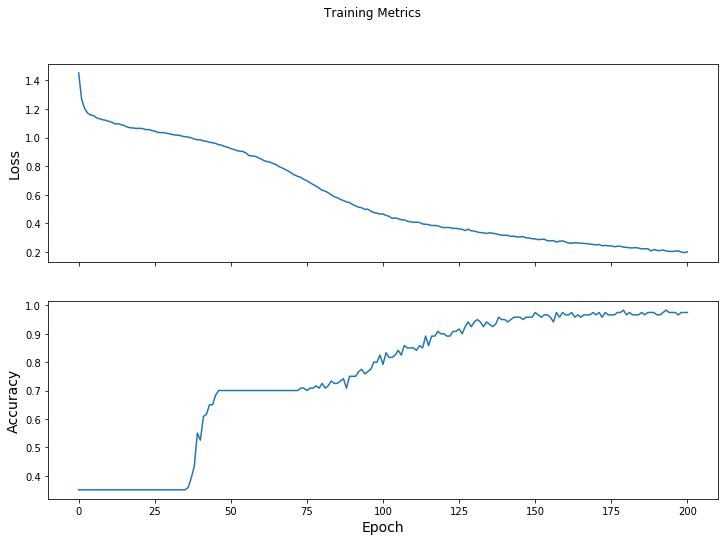

In [11]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

## Evaluate the Model's Effectiveness

Evaluating means determining how effectively the model makes predictions. To determine the model's effectiveness at Iris classification, pass some sepal and petal measurements to the model and ask the model to predict what Iris species they represent. Then compare the model's prediction against the actual label.

### Set Up the Test Dataset

To fairly assess a model's effectiveness, the examples used to evaluate a model must be different from the examples used to train the model.

In [ ]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)             # skip header row
test_dataset = test_dataset.map(parse_csv)      # parse each row with the funcition created earlier
test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset = test_dataset.batch(32)           # use the same batch size as the training set

### Evaluate the Model on the Test Dataset

In [13]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in tfe.Iterator(test_dataset):
    prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
    test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


### Use the Trained Model to Make Predictions

In [14]:
class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    name = class_ids[class_idx]
    print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris setosa
Example 1 prediction: Iris versicolor
Example 2 prediction: Iris virginica


According to the tutorial, these predictions look good!

## Things to Note About TensorFlow and the Tutorial

- The tutorial does not dive into machine learning principles, such as how to pick the best number of neurons and hidden layers of a keras Sequential model, what the bach size for the dataset should be, or the number of epochs you loop over the dataset collection when training the dataset.
- Need more experience with TensorFlow function parameters and notation.
- Need to investigate more about loss, gradient, and optimizer functions.